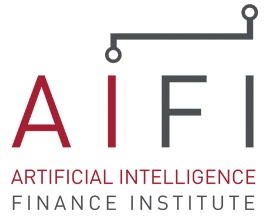


# Bootcamp - Python and Coding - Supervised Machine Learning - Post Processing


# About this Notebook


__Equalized Odds Post-processing (Fairlearn)__: This is a fairness-enhancing post-processing technique that solves a linear program to find probabilities with which to change predicted labels to optimize Equalized Odds (a fairness metric). It ensures that, for every group identified by the sensitive feature(s), the error rates for predicting the positive outcome are approximately equal, and similarly for predicting the negative outcome. [Link for more info](https://fairlearn.org/)



__CalibratedEqOddsPostprocessing (Fairlearn)__: This is another post-processing technique that tries to ensure fairness across different groups as defined by a sensitive feature. It uses a test set to derive a transformation that adjusts the output of a binary classifier to satisfy the 'equalized odds' criterion, i.e., it aims to have equal false positive and false negative rates for different groups. This adjustment is based on the classifier's scores on the test set, not the true labels.



__Reject Option Classification (aif360)__: Reject Option Classification is a post-processing technique for machine learning models that introduces a 'reject option'. If a prediction falls within a certain region where the classifier is less certain, it chooses not to make a decision, thereby potentially improving fairness by avoiding uncertain predictions that may be biased. [Link to library documentation](https://aif360.readthedocs.io/en/latest/)

__Statistical Parity Difference (aif360__): This is a measure of fairness used in fair machine learning. Statistical parity difference is the difference in the probability of positive outcomes for the unprivileged and privileged groups. If the statistical parity difference is zero, it implies that both groups have the same probability of getting positive outcomes (which is often interpreted as the decision process being fair with respect to the groups). However, it's worth noting that this interpretation assumes that the two groups are otherwise identical, which might not be the case in complex real-world scenarios. 

# Imports

In [13]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric

import warnings
warnings.filterwarnings("ignore")

## Equalized Odds Post-processing

### Data Generation

This section generates a synthetic dataset of 200 instances with 5 features each, out of which 3 are informative. In this context, we are assuming that the first feature is the sensitive attribute (e.g., gender), which we are trying to protect against unfair decisions.

In [39]:
# Generate a sample dataset of 200 people applying for credit
np.random.seed(42)
X, y = make_classification(n_samples=200, n_features=5, n_informative=3, n_classes=2, random_state=42)

# Let's say the first feature is gender, which is a sensitive feature in our scenario
sensitive_features = X[:, 0]

### Data Splitting

The dataset is split into training and test sets. The train_test_split function is used to randomly split the data, with 80% of the instances used for training the model, and the remaining 20% for testing the model's performance.

In [43]:

# Split the dataset and the sensitive features into train and test sets
X_train, X_test, y_train, y_test, sensitive_features_train, sensitive_features_test = train_test_split(X, y, sensitive_features, test_size=0.2, random_state=42)

test = train_test_split(X, y, sensitive_features, test_size=0.2, random_state=42)

### Model Definition and Training


Here, a logistic regression model is defined and then trained using the training data. We use the ExponentiatedGradient method with a demographic parity constraint, aiming for similar selection rates across different groups.

In [ ]:
# Define a logistic regression estimator
estimator = LogisticRegression()

# Define the ExponentiatedGradient instance with a demographic parity constraint
unmitigated_predictor = ExponentiatedGradient(estimator=estimator, constraints=DemographicParity())
unmitigated_predictor.fit(X_train, y_train, sensitive_features=sensitive_features_train)


### Model Prediction and Evaluation (Before Post-processing)


The trained model is then used to predict the outcomes for the test data. The prediction performance is evaluated by computing the confusion matrix, which shows the number of true positives, true negatives, false positives, and false negatives.

In [ ]:
# Predict on the test set
y_pred = unmitigated_predictor.predict(X_test)

# Compute the confusion matrix before Equalized Odds post-processing
conf_matrix_before = confusion_matrix(y_test, y_pred)
print("Confusion matrix before Equalized Odds post-processing:\n", conf_matrix_before)


### Model Training with Equalized Odds Post-processing

This section applies the ExponentiatedGradient algorithm again but this time with an "Equalized Odds" constraint, which ensures equal false positive and true positive rates across different groups. This algorithm is trained on the training set with an L2-constraint on group size difference (`eps`) and a maximum number of iterations (`max_iter`).

In [ ]:
# Apply Equalized Odds post-processing using the ExponentiatedGradient algorithm with an L2-constraint on group size difference
constraint = EqualizedOdds()
eps = 0.1
max_iter = 1000
eopp = ExponentiatedGradient(estimator=estimator, constraints=constraint, eps=eps, max_iter=max_iter)
eopp.fit(X_train, y_train, sensitive_features=sensitive_features_train)


### Model Prediction and Evaluation (After Post-processing)

The model trained with Equalized Odds post-processing is then used to predict the outcomes for the test data. The prediction performance is again evaluated by computing the confusion matrix, showing how the model's predictions have changed after applying the fairness enhancement method.

In [44]:
# Predict on the test set after post-processing
y_pred_post = eopp.predict(X_test)

# Compute the confusion matrix after post-processing
conf_matrix_after = confusion_matrix(y_test, y_pred_post)
print("Confusion matrix after Equalized Odds post-processing:\n", conf_matrix_after)


Confusion matrix before Equalized Odds post-processing:
 [[10 12]
 [ 8 10]]
Confusion matrix after Equalized Odds post-processing:
 [[14  8]
 [ 5 13]]


## CalibratedEqOddsPostprocessing

### Applying Trained Logistic Regression Model on Training Data

This line applies the previously trained logistic regression model to the training data to generate predicted scores.

In [ ]:
# Apply the logistic regression model to the training data
dataset_train_copy.scores = unmitigated_predictor.predict(dataset_train_copy.features)

### Creating the Predicted Training Dataset

This code create a copy of the original training dataset and replace its labels with the predicted scores to form a predicted dataset.

In [ ]:
# Create the predicted dataset
dataset_train_pred = dataset_train_copy.copy()
dataset_train_pred.labels = dataset_train_copy.scores

### Defining Calibrated Equal Odds Post-processing Instance

Here, we define an instance of the Calibrated Equal Odds Post-processing (CEOP) class, specifying unprivileged and privileged groups, and setting the cost constraint to `false positive rate (fpr)`.

In [ ]:
# Define the CalibratedEqOddsPostprocessing instance
cpp = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, 
                                     privileged_groups=privileged_groups, 
                                     cost_constraint='fpr')

### Fitting Calibrated Equal Odds Post-processing Instance

This following line fits the CEOP instance to the original and the predicted training datasets, calibrating the post-processing steps.

In [ ]:
# Fit the CEOP instance using the train dataset and the scores predicted by the unmitigated predictor
cpp = cpp.fit(dataset_train_copy, dataset_train_pred)

### Applying Trained Logistic Regression Model on Test Data

Similarly to step 1, we use the logistic regression model to generate predicted scores for the test dataset.

In [ ]:
# Apply the logistic regression model to the test data
dataset_test_copy.scores = unmitigated_predictor.predict(dataset_test_copy.features)


### Creating the Predicted Test Dataset

We create a predicted test dataset by replacing the labels in a copy of the original test dataset with the predicted scores.

In [ ]:
# Create the predicted dataset for test data
dataset_test_pred = dataset_test_copy.copy()
dataset_test_pred.labels = dataset_test_copy.scores

### Bias Mitigation using Calibrated Equal Odds Post-processing

We use the fitted CEOP instance to generate predictions on the test dataset, mitigating bias as per the calibrated post-processing.

In [ ]:
# Predict using the fitted CEOP instance to mitigate bias
dataset_transf_test = cpp.predict(dataset_test_pred)

### Comparison of Model Performance before and after Post-processing

Lastly, we compare the fairness metrics, particularly accuracy, before and after the post-processing step. This lets us evaluate the impact of our bias mitigation process.

In [28]:
# Compare the fairness metrics before and after the post-processing
y_pred_before = dataset_test_copy.labels
y_pred_after = dataset_transf_test.labels

print("Accuracy score before post-processing: ", accuracy_score(dataset_test_copy.labels, y_pred_before))
print("Accuracy score after post-processing: ", accuracy_score(dataset_test_copy.labels, y_pred_after))


Accuracy score before post-processing:  1.0
Accuracy score after post-processing:  0.45


## Statistical Parity Difference

### Synthetic Dataset Creation

This code generates a synthetic dataset with 500 samples and 2 informative features. The weights parameter ensures a class distribution of 60%-40%.

In [ ]:
# Create a synthetic dataset
np.random.seed(0)
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, weights=[0.6, 0.4], random_state=0)


### Sensitive Attribute Definition and Dataset Split

This section of the code defines the sensitive attribute as whether 'Income' is above or below its median value. It also splits the dataset into training and test sets.

In [ ]:
# Define the sensitive feature as being whether the 'Income' is above or below its median
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sensitive_attr_train = (X_train[:, 0] > np.median(X[:, 0])).astype(int)
sensitive_attr_test = (X_test[:, 0] > np.median(X[:, 0])).astype(int)


### DataFrame Creation

This code converts the training and test data into pandas DataFrames for easier data manipulation.

In [ ]:
# Create dataframes
df_train = pd.DataFrame(X_train, columns=['Income', 'Employment Years'])
df_train['Credit Approval'] = y_train
df_train['Income'] = sensitive_attr_train

df_test = pd.DataFrame(X_test, columns=['Income', 'Employment Years'])
df_test['Credit Approval'] = y_test
df_test['Income'] = sensitive_attr_test

### BinaryLabelDataset Creation

In the following, the dataframes are converted into BinaryLabelDataset instances which is the required format for Fairlearn's bias mitigation tools.

In [ ]:
# Create BinaryLabelDatasets
dataset_train = BinaryLabelDataset(df=df_train, label_names=['Credit Approval'], protected_attribute_names=['Income'], favorable_label=1, unfavorable_label=0)
dataset_test = BinaryLabelDataset(df=df_test, label_names=['Credit Approval'], protected_attribute_names=['Income'], favorable_label=1, unfavorable_label=0)

### Classifier Training

A logistic regression classifier is trained on the training dataset.

In [ ]:
# Train a classifier
classifier = LogisticRegression(solver='liblinear')
classifier.fit(X_train, y_train)

###  Prediction Probability Calculation

The trained classifier is applied to the test set to generate predicted probabilities.

In [ ]:
# Apply the classifier to the test set to get predicted probabilities
y_pred_prob = classifier.predict_proba(X_test)[:,1]

### Creation of Dataset with Predicted Probabilities

The predicted probabilities are added to the test dataset.

In [ ]:
# Create dataset with predicted probabilities
dataset_test_pred_prob = dataset_test.copy(deepcopy=True)
dataset_test_pred_prob.scores = y_pred_prob.reshape(-1,1)

### ROC Instance Definition

A Reject Option Classification (ROC) instance is defined with the specified parameters.

In [ ]:
# Define the ROC instance
roc = RejectOptionClassification(unprivileged_groups=[{'Income': 0}], privileged_groups=[{'Income': 1}], 
                                 low_class_thresh=0.01, high_class_thresh=0.99, num_class_thresh=100, num_ROC_margin=50,
                                 metric_name="Statistical parity difference",
                                 metric_ub=0.05, metric_lb=-0.05)

### ROC Instance Fitting and Application

The ROC instance is then fit to the test dataset and the dataset with predicted probabilities. The fitted instance is then used to predict the test set labels.

In [ ]:
# Fit the ROC instance and apply to the predicted labels
roc = roc.fit(dataset_test, dataset_test_pred_prob)
dataset_test_pred_transf = roc.predict(dataset_test_pred_prob)

### Fairness Metrics Calculation

This final section compares the statistical parity difference before and after the ROC.

In [34]:
# Compare the fairness metrics before and after transformation
metric_test_bef = BinaryLabelDatasetMetric(dataset_test_pred_prob,
                                           unprivileged_groups=[{'Income': 0}],
                                           privileged_groups=[{'Income': 1}])

metric_test_aft = BinaryLabelDatasetMetric(dataset_test_pred_transf,
                                           unprivileged_groups=[{'Income': 0}],
                                           privileged_groups=[{'Income': 1}])

print("Statistical parity difference before ROC:", metric_test_bef.statistical_parity_difference())
print("Statistical parity difference after ROC:", metric_test_aft.statistical_parity_difference())


Statistical parity difference before ROC: 0.040000000000000036
Statistical parity difference after ROC: 0.0
